## Импорт библиотек

In [2]:
import sqlalchemy
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Подключение к бд

In [3]:
# 1. Настраиваем параметры подключения
DB_USER = 'postgres'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'Udacity'

# 2. Создаем строку подключения
connection_string = f'postgresql://{DB_USER}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# 3. Создаем движок подключения
engine = sqlalchemy.create_engine(connection_string)

## Выгружаем данные из бд

In [24]:
qerry = """
SELECT *
FROM ab_data_clean
order by "timestamp" DESC
"""

df = pd.read_sql(qerry, engine)
df['date'] = pd.to_datetime(df['timestamp']).dt.floor('D')
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 275629 entries, 0 to 275628
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       275629 non-null  int64         
 1   timestamp     275629 non-null  str           
 2   group         275629 non-null  str           
 3   landing_page  275629 non-null  str           
 4   converted     275629 non-null  int64         
 5   date          275629 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(2), str(3)
memory usage: 12.6 MB


## Первичный анализ питон

Распределения среднее конверсии по дням

Text(0.5, 1.0, 'Сравнение конверсии по группам с 95% доверительным интервалом')

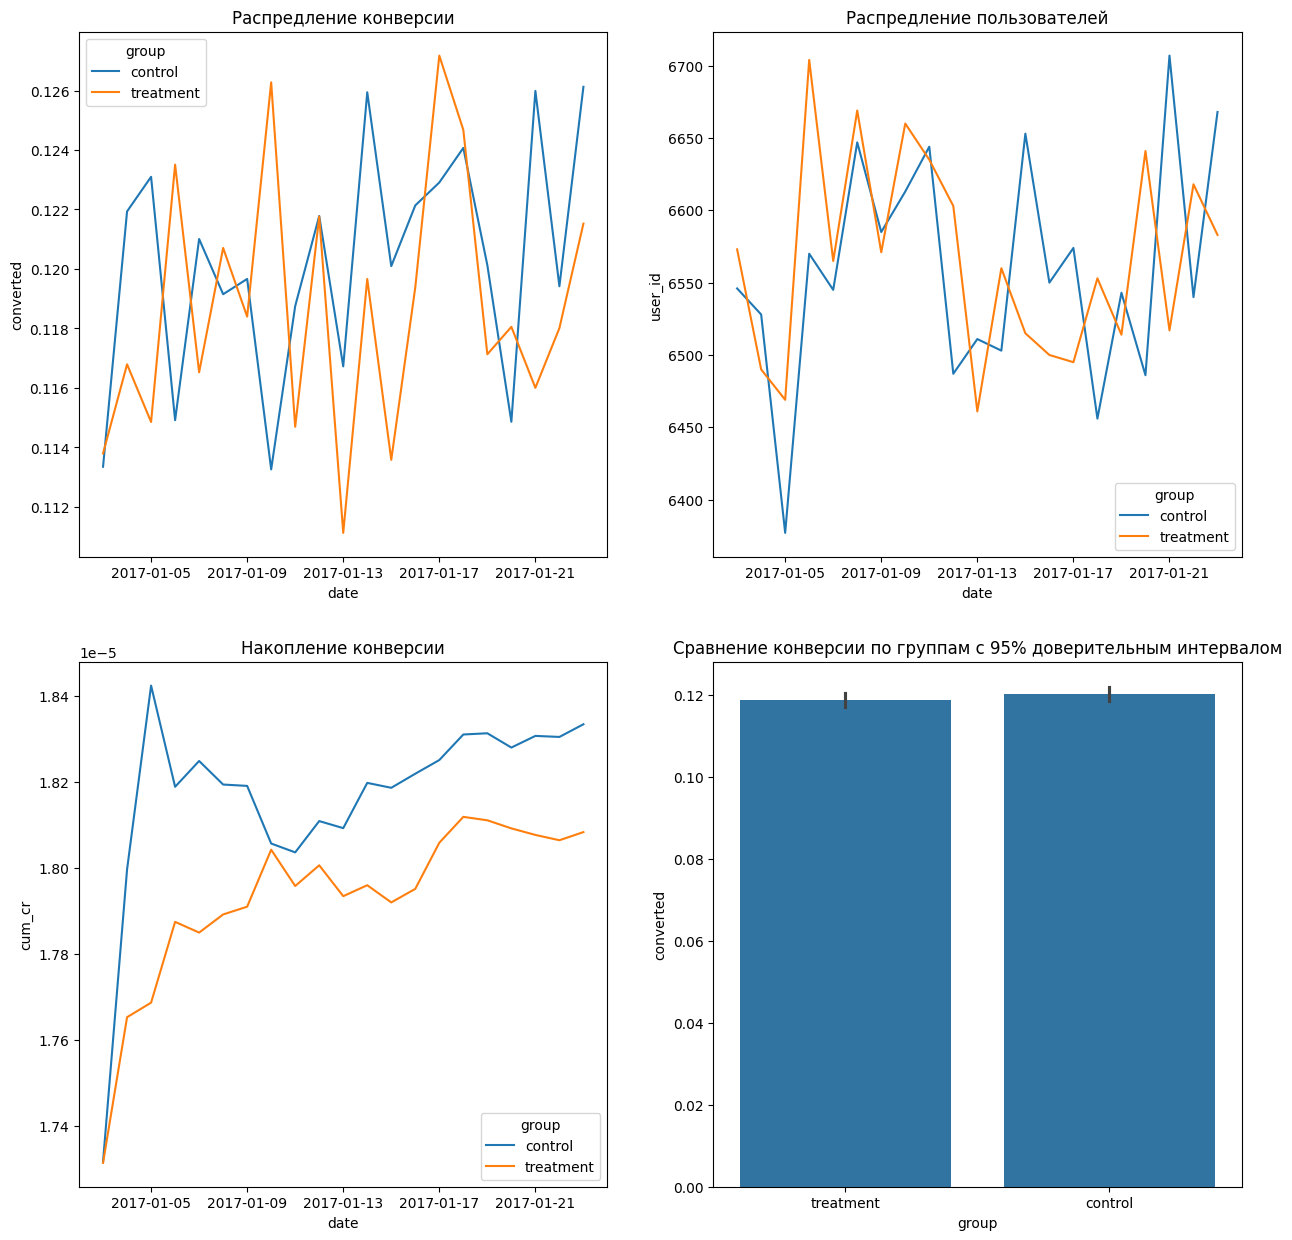

In [30]:
daily = df.groupby(['date', 'group']) \
          .agg({'user_id':'count','converted':'mean'}) \
          .reset_index().rename(columns={'timestamp':'date'})
daily['cum_users'] = daily.groupby('group')['user_id'].cumsum()
daily['cum_converted'] = daily.groupby('group')['converted'].cumsum()

# 3. Вычисляем Кумулятивную Конверсию (Cumulative CR)
daily['cum_cr'] = daily['cum_converted'] / daily['cum_users']

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.lineplot(data=daily, x='date', y='converted', hue='group', ax=axes[0, 0])
axes[0, 0].set_title('Распредление конверсии')
sns.lineplot(data=daily, x='date', y='user_id', hue='group', ax=axes[0, 1])
axes[0, 1].set_title('Распредление пользователей')
sns.lineplot(data=daily, x='date', y='cum_cr', hue='group', ax=axes[1, 0])
axes[1, 0].set_title('Накопление конверсии')
sns.barplot(data=df, x='group', y='converted', ax=axes[1, 1], errorbar=('ci', 95))
axes[1, 1].set_title('Сравнение конверсии по группам с 95% доверительным интервалом')